# Heading

#### Import Python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_stiles as altstiles
import numpy as np

In [3]:
alt.themes.register("stiles", altstiles.theme)
alt.themes.enable("grid")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

## Read data

#### Migration trends from `migration` directory

In [5]:
migration_df = pd.read_csv(
    "../migration/data/processed/irs_migration_decade_net.csv",
    dtype={"fips": "str"},
)

In [6]:
migration_df.head()

fips       county_name state_abbr    left  arrived     net
0  04013   Maricopa County         AZ  530616   671812  141196
1  32003      Clark County         NV  291987   392234  100247
2  48453     Travis County         TX  425184   496981   71797
3  06065  Riverside County         CA  376481   437530   61049
4  12071        Lee County         FL  113530   168436   54906

#### Add population trends from the `census` directory

In [30]:
pop_df = pd.read_csv(
    "../census/data/processed/decennial_census_county_pop_1990-00-10-20.csv",
    dtype={"fips": "str", "state_fips": "str", "county_fips": "str"},
)

In [31]:
pop_df.head()

state_fips county_fips        county_name    state_name ap_name      1990  \
0         08         035     Douglas County      Colorado   Colo.   60391.0   
1         13         117     Forsyth County       Georgia     Ga.   44083.0   
2         51         107     Loudoun County      Virginia     Va.   86129.0   
3         48         491  Williamson County         Texas   Texas  139551.0   
4         46         083     Lincoln County  South Dakota    S.D.   15427.0   

       2000      2010      2020  change_1990_2020  change_2000_2020  \
0  175766.0  285465.0  357978.0            492.77            103.67   
1   98407.0  175511.0  251283.0            470.02            155.35   
2  169599.0  312311.0  420959.0            388.75            148.21   
3  249967.0  422679.0  609017.0            336.41            143.64   
4   24131.0   44828.0   65161.0            322.38            170.03   

   change_2010_2020   fips  
0             25.40  08035  
1             43.17  13117  
2             34.79  51107  
3             44.08  48491  
4             45.36  46083

#### Merge population and migration

In [32]:
mig_pop_df = pd.merge(migration_df, pop_df, on=["fips", "county_name"])

#### Migration as share of population

In [33]:
mig_pop_df["net_pct_pop"] = (mig_pop_df["net"] / mig_pop_df["2020"]) * 100

In [46]:
mig_pop_df.sort_values("change_1990_2020", ascending=False).head()

fips        county_name state_abbr    left  arrived    net state_fips  \
34   08035     Douglas County         CO   84523   104874  20351         08   
40   13117     Forsyth County         GA   36514    52704  16190         13   
35   51107     Loudoun County         VA   79581    99442  19861         51   
6    48491  Williamson County         TX  129075   179698  50623         48   
136  46083     Lincoln County         SD   13943    19212   5269         46   

    county_fips    state_name ap_name      1990      2000      2010      2020  \
34          035      Colorado   Colo.   60391.0  175766.0  285465.0  357978.0   
40          117       Georgia     Ga.   44083.0   98407.0  175511.0  251283.0   
35          107      Virginia     Va.   86129.0  169599.0  312311.0  420959.0   
6           491         Texas   Texas  139551.0  249967.0  422679.0  609017.0   
136         083  South Dakota    S.D.   15427.0   24131.0   44828.0   65161.0   

     change_1990_2020  change_2000_2020  change_2010_2020  net_pct_pop  
34             492.77            103.67             25.40     5.684986  
40             470.02            155.35             43.17     6.442935  
35             388.75            148.21             34.79     4.718037  
6              336.41            143.64             44.08     8.312247  
136            322.38            170.03             45.36     8.086125

---

#### Damage estimates from `01-climate-change-damage`

In [35]:
damage_df = pd.read_csv(
    "data/processed/climate-change-damage-estimates.csv",
    dtype={"county_fips_code": str},
).rename(columns={"county_fips_code": "fips"})

In [36]:
damage_df.head()

state_code      county_name   fips  county_population_in_2012  \
0         FL     Union County  12125                      15239   
1         FL    DeSoto County  12027                      34745   
2         FL  Hernando County  12053                     173100   
3         FL     Dixie County  12029                      16063   
4         TX    Zavala County  48507                      11996   

   county_income_in_2012  5th_percentile_damages  17th_percentile_damages  \
0                  17249                 11.3580                17.516001   
1                  20798                 14.1640                17.632999   
2                  31202                 11.9270                16.339001   
3                  22932                  9.3362                13.878000   
4                  21930                 11.9800                15.423000   

   median_damages  83rd_percentile_damages  95th_percentile_damages  
0       27.943001                45.268002                61.369999  
1       23.632999                33.765999                43.431999  
2       23.563999                39.046001                51.025002  
3       21.292000                34.236000                47.027000  
4       21.072001                28.188999                37.020000

---

## Merge

#### Damage estimates vs. pop growth

In [37]:
df = pd.merge(
    mig_pop_df,
    damage_df,
    on=["fips", "county_name"],
)

In [38]:
df.head()

fips       county_name state_abbr    left  arrived     net state_fips  \
0  04013   Maricopa County         AZ  530616   671812  141196         04   
1  32003      Clark County         NV  291987   392234  100247         32   
2  48453     Travis County         TX  425184   496981   71797         48   
3  06065  Riverside County         CA  376481   437530   61049         06   
4  12071        Lee County         FL  113530   168436   54906         12   

  county_fips  state_name ap_name       1990       2000       2010       2020  \
0         013     Arizona   Ariz.  2122101.0  3072149.0  3817117.0  4420568.0   
1         003      Nevada    Nev.   741459.0  1375765.0  1951269.0  2265461.0   
2         453       Texas   Texas   576407.0   812280.0  1024266.0  1290188.0   
3         065  California  Calif.  1170413.0  1545387.0  2189641.0  2418185.0   
4         071     Florida    Fla.   335113.0   440888.0   618754.0   760822.0   

   change_1990_2020  change_2000_2020  change_2010_2020  net_pct_pop  \
0            108.31             43.89             15.81     3.194069   
1            205.54             64.67             16.10     4.425015   
2            123.83             58.84             25.96     5.564848   
3            106.61             56.48             10.44     2.524579   
4            127.03             72.57             22.96     7.216668   

  state_code  county_population_in_2012  county_income_in_2012  \
0         AZ                    3942900                  40424   
1         NV                    1998600                  38713   
2         TX                    1097100                  52285   
3         CA                    2268000                  31879   
4         FL                     644990                  40248   

   5th_percentile_damages  17th_percentile_damages  median_damages  \
0                  3.3767                   5.1159          7.7618   
1                  2.8945                   4.6669          6.8005   
2                  2.9998                   3.9860          5.6715   
3                  3.4363                   5.9797          9.0895   
4                  7.9112                  10.3420         14.1650   

   83rd_percentile_damages  95th_percentile_damages  
0                11.181000                  14.2900  
1                 9.635400                  12.4160  
2                 7.614400                   9.8619  
3                13.558000                  17.9310  
4                21.306999                  28.1420

#### Correlation between net migration and damages? 

In [40]:
df[["state_code", "county_name", "95th_percentile_damages", "change_1990_2020"]].corr()

95th_percentile_damages  change_1990_2020
95th_percentile_damages                 1.000000         -0.085558
change_1990_2020                       -0.085558          1.000000

#### Questions

In [18]:
# In the places with the highest risk or damage assessment, how many are growing?
# In the places with the lowest risk or damage assessment, how many are growing?

In [44]:
df.sort_values("change_1990_2020", ascending=False).head(50)[
    "95th_percentile_damages"
].mean()

10.387430831400001

In [43]:
df.sort_values("change_1990_2020", ascending=False).tail(50)[
    "95th_percentile_damages"
].mean()

18.73417394778

---

## Geography

#### Counties shapefile

In [21]:
gdf_src = gpd.read_file("data/raw/geo/geo.shp")

In [22]:
gdf = gdf_src[
    [
        "STCOFIPS",
        "COUNTY",
        "COUNTYTYPE",
        "STATE",
        "geometry",
    ]
].copy()

In [23]:
gdf.columns = gdf.columns.str.lower()

<AxesSubplot:>

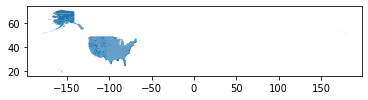

In [24]:
gdf.plot()

In [25]:
gdf

stcofips      county countytype     state  \
0       21115     Johnson     County  Kentucky   
1       21117      Kenton     County  Kentucky   
2       21119       Knott     County  Kentucky   
3       21121        Knox     County  Kentucky   
4       21123       Larue     County  Kentucky   
...       ...         ...        ...       ...   
3137    56037  Sweetwater     County   Wyoming   
3138    56039       Teton     County   Wyoming   
3139    56041       Uinta     County   Wyoming   
3140    56043    Washakie     County   Wyoming   
3141    56045      Weston     County   Wyoming   

                                               geometry  
0     POLYGON ((-82.61240 37.87928, -82.61688 37.877...  
1     POLYGON ((-84.50617 39.09518, -84.50333 39.091...  
2     POLYGON ((-82.94855 37.50317, -82.94733 37.501...  
3     POLYGON ((-83.58953 36.95579, -83.58949 36.954...  
4     POLYGON ((-85.52129 37.55435, -85.52019 37.553...  
...                                                 ...  
3137  POLYGON ((-109.04388 42.26369, -108.87568 42.2...  
3138  POLYGON ((-110.05319 44.00803, -110.05365 43.8...  
3139  POLYGON ((-110.04801 41.57802, -110.04909 41.3...  
3140  POLYGON ((-107.14682 44.16567, -107.12860 44.1...  
3141  POLYGON ((-104.05450 44.18039, -104.05460 44.1...  

[3142 rows x 5 columns]

---

## Merge

In [26]:
df_merged = gpd.GeoDataFrame(pd.merge(df, gdf, left_on="fips", right_on="stcofips"))

---

## Exports

#### Geo file

In [27]:
df_merged.to_file(
    "data/processed/migration_climate_damage_counties.geojson", driver="GeoJSON"
)

/Users/stiles/.pyenv/versions/3.9.9/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [28]:
df_merged.head(100).to_file(
    "data/processed/migration_climate_damage_counties_top100.geojson", driver="GeoJSON"
)

/Users/stiles/.pyenv/versions/3.9.9/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [29]:
df_merged.tail(100).to_file(
    "data/processed/migration_climate_damage_counties_bottom100.geojson",
    driver="GeoJSON",
)

/Users/stiles/.pyenv/versions/3.9.9/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
